# Stochastic Processes: <br>Data Analysis and Computer Simulation
<br>


# Brownian motion 3: data analysis
<br>


# 2. Mean square displacement and diffusion constant
<br>

# Calculating the diffusion constant from simulation data

# 2.1. Perform simulation (at equilibrium)

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
dim  = 3    # system dimension (x,y,z)
nump = 1000 # number of independent Brownian particles to simulate 
nums = 1024 # number of simulation steps
dt   = 0.05 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set temperatute, k_B T
std  = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)
np.random.seed(0) # initialize random number generator with a seed=0
R = np.zeros([nump,dim]) # array to store current positions and set initial condition Eq.(F12)
V = np.zeros([nump,dim]) # array to store current velocities and set initial condition Eq.(F12)
W = np.zeros([nump,dim]) # array to store current random forcces
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time = np.zeros([nums]) # an array to store time at all steps
for i in range(nums): # repeat the following operations from i=0 to nums-1
    W = std*np.random.randn(nump,dim) # generate an array of random forces according to Eqs.(F10) and (F11)
    V = V*(1-zeta/m*dt)+W/m # update velocity via Eq.(F9)
    R = R + V*dt # update position via Eq.(F5)
    Rs[i]=R # accumulate particle positions at each step in an array Rs
    Vs[i]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i]=W # accumulate random forces at each step in an array Ws
    time[i]=i*dt # store time in each step in an array time

# 2.2. Mean square displacement vs. time

- Calculate the mean square displacement, and compare it with the following theoretical result (see the derivation for Eq.(30)).
$$
\langle[\mathbf{R}(t)-\mathbf{R}(0)]^2\rangle=6Dt\tag{H1}
$$
<br>
- Note that the diffusion constant can be easily calculated from the mean square displacement by integrating both sides of Eq.(H1) with respect to time
$$
D = \frac{1}{3 T^2} \int_0^T \mathrm{d} t \,\langle[\mathbf{R}(t) - \mathbf{R}(0)]^2\rangle\tag{H2}
$$

D = 1.0 (Theoretical)
D = 0.926874089843 (Simulation via MSD)


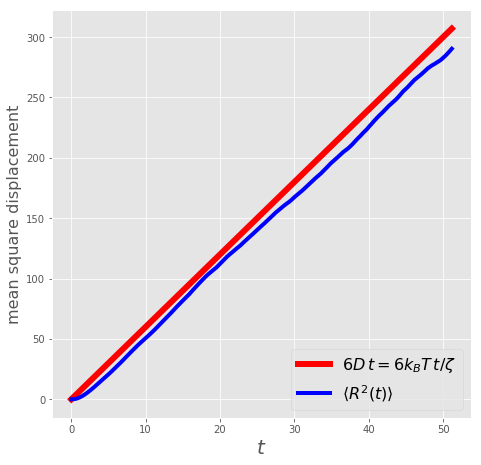

In [2]:
# mean square displacement vs time
msd = np.zeros([nums])
for i in range(nums): # loop over time steps
    for n in range(nump): # loop over particles
        msd[i]=msd[i]+np.linalg.norm(Rs[i,n,:])**2 # (R(t) - R(0))^2 = R(t)^2, since R(0) = 0 for all particles
    msd[i] = msd[i]/nump  # average over particles
dmsd = np.trapz(msd, dx=dt)/ (3*(nums*dt)**2) # integrate using trapezoidal rule
print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.set_xlabel(r"$t$", fontsize=20)
ax.set_ylabel(r"mean square displacement", fontsize=16)
ax.plot(time,6*kBT/zeta*time,'r',lw=6, label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time,msd,'b',lw=4, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=16,loc=4)
plt.show()

# 2.3. Diffusion constant and Velocity auto-correlation function

- Calculate the velocity auto-correlation function, and evaluate the diffusion constant using the Green-Kubo formula (see the derivation for Eq.(49)).

$$
D=\frac{1}{3}\int_o^\infty \varphi_V(t) dt
\tag{H3}
$$

D = 1.0 (Theoretical)
D = 0.944777284634 (Simulation via Green-Kubo)


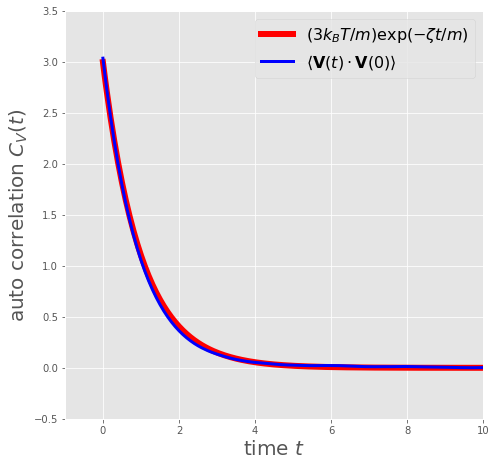

In [3]:
# compute self-correlation of vector v
def auto_correlate(v):
    # np.correlate computes C_{v}[k] = sum_n v[n+k] * v[n]
    corr = np.correlate(v,v,mode="full") # correlate returns even array [0:2*nums-1] centered at nums-1
    return corr[len(v)-1:]/len(v) # take positive values and normalize by number of points
corr = np.zeros([nums])
for n in range(nump):
    for d in range(dim):
        corr = corr + auto_correlate(Vs[:,n,d]) # correlation of d-component of velocity for particle n
corr=corr/nump #average over all particles
print('D =',kBT/zeta,'(Theoretical)')
print('D =',np.trapz(corr,dx=dt)/3,'(Simulation via Green-Kubo)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.plot(time,dim*kBT/m*np.exp(-zeta/m*time),'r',lw=6, label=r'$(3k_BT/m)\exp(-\zeta t/m)$')
ax.plot(time,corr,'b',lw=3,label=r'$\langle\mathbf{V}(t)\cdot \mathbf{V}(0)\rangle$')
ax.set_xlabel(r"time $t$", fontsize=20)
ax.set_ylabel(r"auto correlation $C_V(t)$", fontsize=20)
ax.set_xlim(-1,10)
ax.set_ylim(-0.5,3.5)
ax.legend(fontsize=16)
plt.show()

# 2.4. Perform simulation under external force (out of equilibrium)

In [5]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D # import Axes3D from `mpl_toolkits.mplot3d`
plt.style.use('ggplot')

In [6]:

dim  = 3    # system dimension (x,y,z)
nump = 1000 # number of independent Brownian particles to simulate 
nums = 1024 # number of simulation steps
dt   = 0.05 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set temperatute, k_B T
F0   = 1.0  # set external drift force
std  = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)
np.random.seed(0) # initialize random number generator with a seed=0
R = np.zeros([nump,dim]) # array to store current positions and set initial condition Eq.(F12)
V = np.zeros([nump,dim]) # array to store current velocities and set initial condition Eq.(F12)
W = np.zeros([nump,dim]) # array to store current random forcces
F = np.zeros([nump,dim]) # array to store external force
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time  = np.zeros([nums]) # an array to store time at all steps
F[:,0]=F0 # constant force along x, zero force in y and z
for i in range(nums): # repeat the following operations from i=0 to nums-1
    W = std*np.random.randn(nump,dim) # generate an array of random forces accordingly to Eqs.(F10) and (F11)
    V = V*(1-zeta/m*dt)+W/m+F/m*dt # update velocity via Eq.(F9)
    R = R + V*dt # update position via Eq.(F5)
    Rs[i]=R # accumulate particle positions at each step in an array Rs
    Vs[i]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i]=W # accumulate random forces at each step in an array Ws
    time[i]=i*dt # store time in each step in an array time

## 2.4.1 plot trajectory in 3D

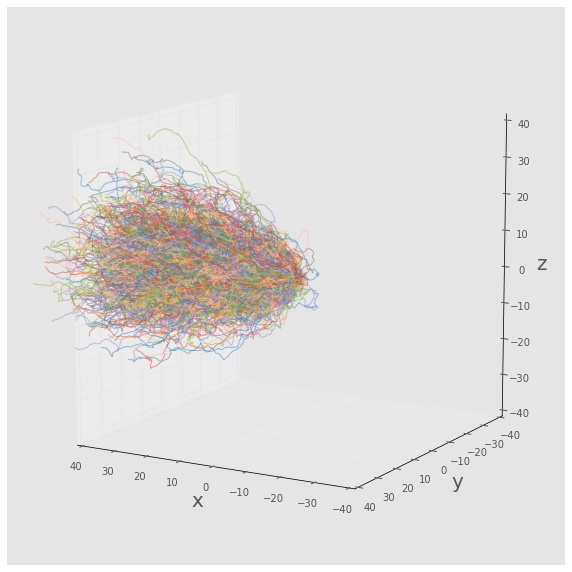

In [8]:
box=80. # set draw area as box^3
fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 2D axes
ax.set_xlim(-box/2,box/2) # set x-range
ax.set_ylim(-box/2,box/2) # set y-range
ax.set_zlim(-box/2,box/2) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
for n in range(nump): # repeat from n=0 to nump-1
    ax.plot(Rs[:,n,0],Rs[:,n,1],Rs[:,n,2],alpha=0.5) # plot trajectiries of all particle
plt.show() # draw plots

# 2.5. Drift velocity under external force

- Calculate the drift velocity $\langle V_x \rangle_{ext}$, and evaluate the diffusion constant using the equation shown here (see the derivation for Eq.(43)).

$$
D=\frac{\langle V_x \rangle_{ext}k_BT}{F_0}
\tag{H4}
$$

D = 1.0 (Theoretical)
D = 0.980302218583 (Simulation with external force)


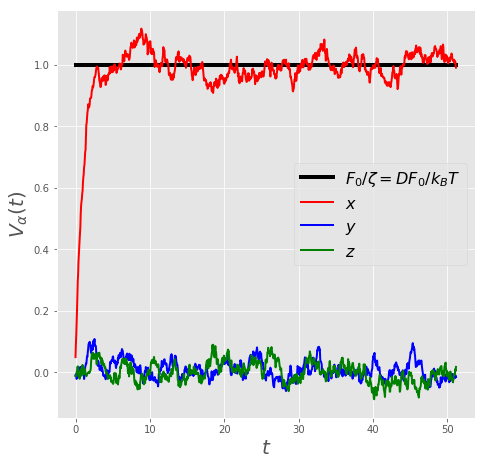

In [5]:
Vsa = np.average(Vs,axis=1) # average over particles (0-axis is time, 1-axis is particles, 2-axis is dimension)
Vx  = np.average(Vsa[:,0]) # time average of (particle averaged) x-velocity
print('D =',kBT/zeta, '(Theoretical)')
print('D =',Vx*kBT/F0,'(Simulation with external force)')
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.set_ylabel(r"$V_{\alpha}(t)$", fontsize=20)
ax.set_xlabel(r"$t$", fontsize=20)
ax.plot(time,F0/zeta*np.ones(nums),'k',lw=4,label=r"$F_0/\zeta=DF_0/k_B T$")
ax.plot(time,Vsa[:,0],'r',lw=2,label="$x$")
ax.plot(time,Vsa[:,1],'b',lw=2,label="$y$")
ax.plot(time,Vsa[:,2],'g',lw=2,label="$z$")
ax.legend(fontsize=16,loc=5)
plt.show()